# Biathlon Data Science Project

* Data source: Real Biatholon Statistics [link](http://www.realbiathlon.com/p/statistics-women.html)
* 2015-2016 Season Biathlon World Cup Womens Shooting Times: [link](http://realbiathlon.sportsontheweb.net/data2/WomenShootingTimes_files/sheet016.htm)
* 2015-2016 Season Biathlon World Cup Womens Results: [link](http://realbiathlon.sportsontheweb.net/data2/WomenResults_files/sheet016.htm)

## Definition of Features

From the metadata on the data source we have the following definition of the features.

*From "shooting_time.csv"*

| Feature  | Description |
|--------------|-------------|
|  Family Name  | Last Name|
|  Given Name  | First Name|
|  Races  |  Number of individual, non-relay races each person competed in over the 2015-16 season|
|  Rg_Time_S |  Average Time for individual to get into standing position, shoot and get out of position, otherwise known as Range Time to shoot Standing|
|  Rg_Time_P |  Average Time for individual to get into prone position, shoot, and get out of position, otherwise known as Range Time to shoot Prone|
|  Penalty Loop  |  Season average penalty loop (approximation)|

*From "skiing_performance.csv"*

| Feature  | Description |
|--------------|-------------|
|  Km/h  |  season's average ski speed in km/h|

*From "shooting_percentage.csv"*

| Feature  | Description |
|--------------|-------------|
|  Hits  |  Number of targets hits|
|  Shots  |  Number of total targets the individual could have hit (Or wanted to hit to not ski any penalty loops)|
|  P%  |  Average percentage of Prone targets hit|
|  S%  |  Average percentage of Standing Targets hit|


*From "15_16_world_cup_results.csv"*

| Feature  | Description |
|--------------|-------------|
|  Average Rank  |  average race rank in individual, non-relay races|
|  World Cup points  |  Overall World Cup score|
|  MS  |  Mass Start World Cup score|
|  Win, Podium, Top 10, Top 20, Top 30, Top 40 %  |  Apercentage for individual, non-relay races|


## What we can do next
<input type="checkbox">  Merge shooting time dataframe with results dataframe to create a target for training our model. Add average rank and world cup points as columns from results file.

<input type="checkbox">  Statistical analysis -- what is the spread of each category? Create a new column of Hits/ Shots (Shooting Percentage) and get rid of % P and % S. Vizualize this. How do we normalize each category?

<input type="checkbox">  Feature selection -- What categories might contribute more to the final ranking? ("Skiing is for show, shooting is for dough").

<input type="checkbox">  Train a model to predict placement. How accurate is it? Would combining data from different years yield better results?

<input type="checkbox">  How have the categories changed throughout the years? Is the sport getting more competitive?

### Merging Dataframes

* Compare statistics for Fastest Skiers and Shooting percentages/shooting times
* Concat First + Last name


In [1]:
import pandas as pd
import matplotlib.pyplot as plt      # matplotlib.pyplot plots data
import seaborn as sns
import datetime

%matplotlib inline

The dataset already contains an index column. We can either set this column as the index in our data frame, our we can choose to drop the first column in our dataset. I am doing the former below. Further, we see a large number of NaN's. Let's go ahead and convert these to 0:00.0 to be consistent. While we're at it, let's also rename the columns to something less confusing.

In [2]:
df_sh_times = pd.read_csv("shooting_time.csv", index_col=0)
df_sh_times = df_sh_times.fillna('0:00.0')
df_sh_times = df_sh_times[['Family Name', 
                           'Given Name', 
                           'Races', 
                           'Rg Time\nP', 
                           'Rg Time\nS', 
                           'Penalty\nLoop' ]]

df_sh_times = df_sh_times.rename(columns={'Rg Time\nP': 'Rg_Time_P',
                                          'Rg Time\nS': 'Rg_Time_S',
                                          'Penalty\nLoop': "Penalty Loop"})
df_sh_times.head()

,Family Name,Given Name,Races,Rg_Time_P,Rg_Time_S,Penalty Loop
1,KAISHEVA,Uliana,1,0:41.8,0:41.7,0:26.0
2,KUMMER,Luise,6,0:48.1,0:45.9,0:26.4
3,HAUSER,Lisa Theresa,24,0:48.3,0:43.6,0:25.3
4,ZDOUC,Dunja,11,0:49.5,0:45.1,0:25.8
5,WIERER,Dorothea,25,0:47.2,0:44.9,0:23.5


We see that the times are stored as string. Let's write a function to convert each of the times to total seconds.

In [3]:
def str_to_sec(val):
    minute, seconds = val.split(":")
    sec, msec = seconds.split(".")
    total_sec = int(minute)*60 + int(sec) + int(msec)/10
    return total_sec

In [4]:
for c in df_sh_times.columns[3::]:
    df_sh_times[c] = df_sh_times[c].apply(lambda x: str_to_sec(x))

df_sh_times['Family Name'] = df_sh_times['Family Name'].apply(lambda x: x.capitalize()) + " " + df_sh_times['Given Name']   
df_sh_times = df_sh_times.drop(["Given Name"], axis=1)
df_sh_times.head()

,Family Name,Races,Rg_Time_P,Rg_Time_S,Penalty Loop
1,Kaisheva Uliana,1,41.8,41.7,26.0
2,Kummer Luise,6,48.1,45.9,26.4
3,Hauser Lisa Theresa,24,48.3,43.6,25.3
4,Zdouc Dunja,11,49.5,45.1,25.8
5,Wierer Dorothea,25,47.2,44.9,23.5


Much better! Now that the data is in a more workable format, let's dive deeper into what the dataset looks like. Some things we might be interested in include the shape, a summary of each column (number of entries, data types etc), and a correlation matrix to pick out any redundancies.

In [5]:
# Look at the shape of the dataframe (number of rows and columns)
print("The shooting times data set now has {rows} rows and {cols} columns after cleaning".format(rows=df_sh_times.shape[0], 
                                                                cols=df_sh_times.shape[1]))

The shooting times data set now has 165 rows and 5 columns after cleaning


In [6]:
# look a a summary of each column (number of entries, data-type etc)
df_sh_times.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 1 to 165
Data columns (total 5 columns):
Family Name     165 non-null object
Races           165 non-null int64
Rg_Time_P       165 non-null float64
Rg_Time_S       165 non-null float64
Penalty Loop    165 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.7+ KB


In [7]:
# Check for any null values
df_sh_times.isnull().values.any()

False

In [8]:
# Now read in the skiing performance data set
df_ski = pd.read_csv("skiing_performance.csv", index_col=0)
df_ski = df_ski[['Family Name', 'Given Name', 'km/h']]
df_ski['Family Name'] = df_ski['Family Name'].apply(lambda x: x.capitalize()) + " " + df_ski['Given Name']
df_ski = df_ski.drop(["Given Name"], axis=1)

df_ski.head()

,Family Name,km/h
1,Makarainen Kaisa,24.08
2,Dorin habert Marie,23.85
3,Eckhoff Tiril,23.74
4,Dahlmeier Laura,23.70
5,Goessner Miriam,23.89


In [9]:
df_ski.isnull().values.any()

False

In [10]:
# Now read in the skiing performance data set
df_sh_per = pd.read_csv("shooting_percentage.csv", index_col=0)
df_sh_per = df_sh_per[['Family Name', 'Given Name', 'Hits', 'Shots', 'P\n %', 'S\n%']]
df_sh_per['Family Name'] = df_sh_per['Family Name'].apply(lambda x: x.capitalize()) + " " + df_sh_per['Given Name']
df_sh_per = df_sh_per.drop(["Given Name"], axis=1)

df_sh_per.head()

,Family Name,Hits,Shots,P %,S %
1,Kupfner Simone,10,10,100.0,100.0
2,Kadeva Daniela,10,10,100.0,100.0
3,Vaillancourt Audrey,19,20,90.0,100.0
4,Runggaldier Alexia,87,93,95.7,91.5
5,Skardino Nadezhda,365,394,92.4,92.9


In [11]:
df_sh_per.isnull().values.any()

False

In [12]:
df_results = pd.read_csv("15_16_world_cup_results.csv")

df_results = df_results[[' Family Name', 
                         'Given Name', 
                         'Average Rank',
                         'Podiums',]]
df_results = df_results.rename(columns={' Family Name': 'Family Name'})

df_results['Family Name'] = df_results['Family Name'].apply(lambda x: x.capitalize()) + " " + df_results['Given Name']   
df_results = df_results.drop(["Given Name"], axis=1)
df_results = df_results.fillna(101)

df_results.head()

,Family Name,Average Rank,Podiums
0,Soukalova Gabriela,4.2,11
1,Dorin habert Marie,6.7,11
2,Wierer Dorothea,8.2,10
3,Makarainen Kaisa,9.6,9
4,Hildebrand Franziska,11.0,5


In [13]:
df = df_sh_per.merge(df_ski, left_on='Family Name', right_on='Family Name')
df = df_sh_times.merge(df, left_on='Family Name', right_on='Family Name')
df = df_results.merge(df, left_on='Family Name', right_on='Family Name')

df.head()

,Family Name,Average Rank,Podiums,Races,Rg_Time_P,Rg_Time_S,Penalty Loop,Hits,Shots,P %,S %,km/h
0,Soukalova Gabriela,4.2,11,25,55.0,50.4,23.4,449,488,95.0,89.1,23.63
1,Dorin habert Marie,6.7,11,25,52.8,51.3,23.3,429,488,94.3,81.6,23.85
2,Wierer Dorothea,8.2,10,25,47.2,44.9,23.5,431,496,91.4,82.5,23.35
3,Makarainen Kaisa,9.6,9,24,54.3,52.9,23.7,390,468,84.3,82.4,24.08
4,Hildebrand Franziska,11.0,5,23,54.2,54.5,23.9,402,448,91.5,87.9,23.46


In [14]:
df.isnull().values.any()
df.shape

(165, 12)

In [15]:
# Look at the shape of the merged dataframe (number of rows and columns)
print("The shooting times data set now has {rows} rows and {cols} columns after cleaning".format(rows=df.shape[0], 
                                                                cols=df.shape[1]))

The shooting times data set now has 165 rows and 12 columns after cleaning


In [16]:
def plot_pretty_corr(df):
    plt.figure(figsize=(12, 12))
    corr = df.corr()
    ax = sns.heatmap(corr,
                    vmin=-1,
                    vmax=1,
                    center=0,
                    cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

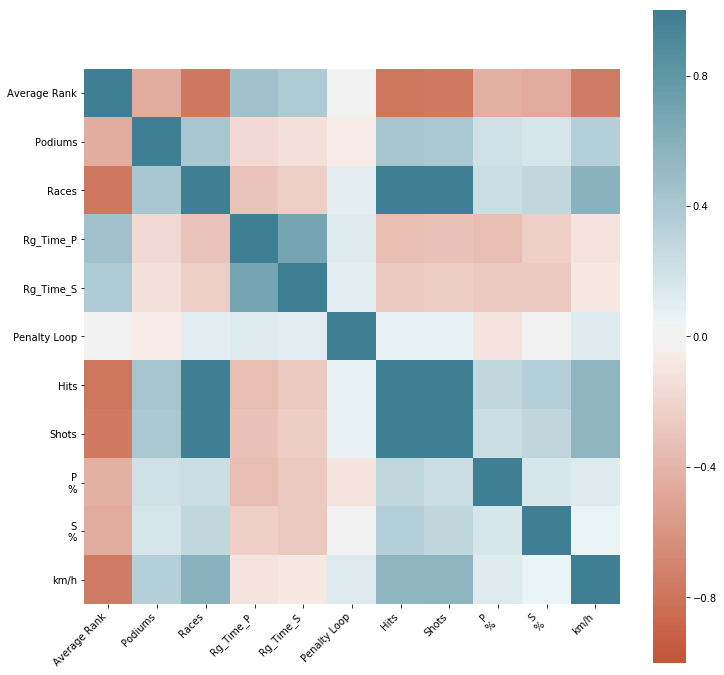

In [17]:
plot_pretty_corr(df)

Hits on shots seem to correlate perfectly. Is there an opputunity to reduce dimensions here?

## What in the world is a Biatholon???

[source](https://adventure.howstuffworks.com/outdoor-activities/snow-sports/biathlon1.htm)

A typical biathlon event requires participants to ski for a certain distance, usually between 3 and 5 kilometers (between 1.86 and 3.1 miles), with .22 caliber rifles strapped to their backs. When they reach the firing range, they must shoot five targets placed 50 meters (165 feet) away. They only have five shots, and for each shot that misses a target, the competitor must ski around a penalty loop of 150 m. This process repeats over three or four additional segments of skiing and shooting.

In a biathlon event, competitors cross-country ski for a pre-determined distance, and then stop at a rifle range to fire at targets. In all events, the targets are 50 meters downrange. In some events, the skiing portion is truly cross-country. In others, skiers race around a course. After each lap around the course, they stop at the shooting range.

Shooting portions are conducted in either the prone or the standing (sometimes known as off-hand) positions. The athletes do not choose the position -- each event requires different shooting positions at specific points in the race. In the standing position, the target area is 11.5 centimeters in diameter. In the prone position, the target is only 4.5 cm wide. In addition, the wrist can't touch the ground while in the prone position.

At the firing range, each competitor has five targets, with one round of ammunition per target. In every event except individual, each missed target results in a 150 m penalty. The penalty includes skiing around a 150 m loop off to the side of the main course. In the individual event, each missed target adds a penalty of one minute to the competitor's final time.

The relay event differs slightly in that the athletes have three extra rounds at each firing range. They still have to strike five targets, but if they miss on any of the first five shots, they can load additional bullets to get the remaining targets. Loading a bullet takes five to seven seconds. Each target that remains standing after all eight shots have been fired results in a trip around the 150 m penalty loop.

### The 2018 PeyongChang Winter Olympic biathlon

The 2018 PeyongChang Winter Olympic biathlon includes five main event types: individual, sprint, pursuit and relay. These events are divided into different distances and split between men's and women's competitions for a total of 11 different events:

* Men's 20 km Individual
* Women's 15 km Individual
* Men's 10 km Sprint
* Women's 7.5 km Sprint
* Women's 10 km Pursuit
* Men's 12.5 km Pursuit
* Men's 4 x 7.5 km Relay
* Women's 4 x 6 km Relay
* Men's 15 km Mass Start
* Women's 12.5 km Mass Start
* 2x6km Women and 2x7.5 km Men Mixed Relay

#### Individual
This is the original biathlon event. Competitors each start 30 seconds apart, skiing five laps around a 3 or 4 km loop. At the end of each lap (except the final lap), competitors shoot. The four shooting portions in order are prone, standing, prone, standing, with five shots each round. Each missed shot adds a one-minute penalty. Standings are determined by overall time, which runs continuously from the moment a competitor leaves the starting line to when he or she crosses the finish line. The winners of this event will finish in under 50 minutes.

#### Sprint
Sprint is similar to the individual, but the distance is shorter (about 10 km total), and there are only two shooting portions: prone, then standing. Each missed target results in one lap around the 150 m penalty loop.

#### Pursuit
The Pursuit is unusual among Olympic events in that a previous event's results determine its competitors. The top 60 competitors from the Sprint qualify for the Pursuit. They start the 12.5 km (10 km for women) event at intervals based on their Sprint finishing times, but the race is actually head-to-head. This means that whoever does well in the Sprint and starts the Pursuit first has an actual head start over the rest of the field, who are constantly in "pursuit." The Pursuit has four shooting portions: prone, prone, standing, standing.

#### Relay
Each relay team has four members. All the first-leg skiers line up at the starting line and begin at the same time. They tend to arrive at the first firing range in the same manner. Each team member skis about 3 or 4 km, shoots prone, then skis the rest of his 7.5 km leg (6 km for women) and shoots standing. Competitors must tag the next team member to start the next leg of the relay. This event is head-to-head. The athletes are not racing against the clock, but directly against each other. Whoever crosses the finish line first wins. Each athlete is given three additional rounds of ammo as way to encourage faster shooting.

#### Mixed Relay
Each team has two women and two men. The order of departure is woman, woman, man, man. The women shoot two rounds at the 6 km mark, the men shoot two rounds at the 7.5 km mark. The competition rules are the same as for Relay.

#### Mass Start
This biathlon event is meant to appeal to spectators. Like Pursuit, entry is determined by prior events. Medal winners in the individual events qualify for Mass Start, with world IBU rankings determining the remaining field of 30. The men ski for 15 m and the women ski for a total of 12.5 km. The four shooting portions are prone, prone, standing, standing. Every time they miss, they must ski a 150 m penalty loop. This is a head-to-head competition, with all the competitors leaving the starting line at the same time.


[read on](https://www.usatoday.com/story/sports/winter-olympics-2018/2018/02/06/biathlon/1079237001/)